Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

# Latent Dirchilet Allocation (LDA) Models (Prepare)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [5]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore
from spacy.lang.en import English
import pandas as pd

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [6]:
path = './data/austen-brontë-split'

In [7]:
nlp = English()

In [27]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [36]:
import os

def gather_data(path_to_data): 
    data = []
    
    for f in os.listdir(path):
        if f[-3:] == 'txt':
            with open(os.path.join(path,f)) as t:
                text = t.read().strip('\n')
                data.append(tokenize(str(text)))
            
    return data

In [37]:
df['tokens'] = gather_data(path)

In [38]:
tokens = gather_data(path)

In [39]:
tokens[0][0:10]

['emma',
 'jane',
 'austen',
 'volume',
 'chapter',
 'emma',
 'woodhouse',
 'handsome',
 'clever',
 'rich']

In [30]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

In [31]:
df['tokens'].head()

0    [emma, jane, austen, volume, chapter, emma, wo...
1    [taylor, wish, pity, mr, weston, thought, agre...
2    [behaved, charmingly, body, punctual, body, be...
3    [native, highbury, born, respectable, family, ...
4    [mention, handsome, letter, mrs, weston, recei...
Name: tokens, dtype: object

## Follow Along

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [40]:
titles = [t[:-4] for t in os.listdir(path)]

In [41]:
titles[:5]

['Austen_Emma0000',
 'Austen_Emma0001',
 'Austen_Emma0002',
 'Austen_Emma0003',
 'Austen_Emma0004']

In [42]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [44]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

In [45]:
len(tokens)

813

### Author DataFrame


In [46]:
df = pd.DataFrame(index=titles, data={'tokkens':tokens})

In [47]:
df.head()

,tokkens
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo..."
Austen_Emma0001,"[taylor, wish, pity, mr, weston, thought, agre..."
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be..."
Austen_Emma0003,"[native, highbury, born, respectable, family, ..."
Austen_Emma0004,"[mention, handsome, letter, mrs, weston, recei..."


In [48]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [49]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [50]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [51]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            tokens = tokenize(str(text))
            yield tokens  #Creates a generator object instead of a list

In [52]:
streaming_data = doc_stream(path)

In [ ]:
next(streaming_data)  #returns one doc at a time from generator

### Gensim LDA Topic Modeling

In [65]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [58]:
id2word.token2id['england']

3987

In [59]:
id2word[3987]

'england'

In [60]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(2754, 1), (3987, 3), (6602, 1), (6819, 1)]

In [61]:
import sys
sys.getsizeof(id2word)

56

In [66]:
len(id2word.keys())

22096

In [67]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.85)

In [68]:
len(id2word.keys())

8103

In [69]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [70]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 4),
 (7, 1),
 (8, 1),
 (9, 1)]

In [71]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [72]:
lda.print_topics()

[(0,
  '0.025*"elinor" + 0.021*"marianne" + 0.010*"edward" + 0.009*"dashwood" + 0.008*"jennings" + 0.008*"willoughby" + 0.008*"sister" + 0.007*"mother" + 0.007*"lucy" + 0.006*"time"'),
 (1,
  '0.006*"little" + 0.005*"like" + 0.004*"thought" + 0.004*"monsieur" + 0.004*"madame" + 0.004*"know" + 0.004*"good" + 0.004*"hand" + 0.003*"day" + 0.003*"time"'),
 (2,
  '0.005*"like" + 0.005*"night" + 0.004*"long" + 0.004*"thought" + 0.004*"door" + 0.004*"little" + 0.004*"time" + 0.004*"day" + 0.003*"house" + 0.003*"saw"'),
 (3,
  '0.009*"sir" + 0.005*"like" + 0.005*"jane" + 0.005*"know" + 0.005*"thought" + 0.004*"good" + 0.004*"heart" + 0.004*"man" + 0.004*"life" + 0.003*"right"'),
 (4,
  '0.009*"miss" + 0.008*"little" + 0.005*"like" + 0.005*"papa" + 0.004*"new" + 0.004*"thought" + 0.004*"day" + 0.004*"came" + 0.004*"come" + 0.004*"think"'),
 (5,
  '0.008*"room" + 0.006*"dancing" + 0.006*"thought" + 0.005*"way" + 0.005*"dance" + 0.005*"like" + 0.004*"day" + 0.004*"door" + 0.004*"time" + 0.003*"li

In [73]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [74]:
topics = [' '.join(t[0:5]) for t in words]

In [77]:
for id, t in enumerate(topics): 
    print(f'-----Topic {id} -----')
    print(f"{t}\n")

-----Topic 0 -----
elinor marianne edward dashwood jennings

-----Topic 1 -----
little like thought monsieur madame

-----Topic 2 -----
like night long thought door

-----Topic 3 -----
sir like jane know thought

-----Topic 4 -----
miss little like papa new

-----Topic 5 -----
room dancing thought way dance

-----Topic 6 -----
jane heart old eye monsieur

-----Topic 7 -----
graham little papa like bretton

-----Topic 8 -----
home soon sir hannah rochester

-----Topic 9 -----
like little rochester sir jane

-----Topic 10 -----
emma harriet miss elton knightley

-----Topic 11 -----
elizabeth miss know think good

-----Topic 12 -----
madame child good little day

-----Topic 13 -----
church little time rome strange

-----Topic 14 -----
bessie reed abbot miss like



## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [78]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [79]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/home/hakujou/anaconda3/envs/u4s1/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.135095  0.035689       1        1  25.826868
1      0.033036 -0.016663       2        1  22.538849
9      0.003467 -0.051299       3        1  14.054945
10    -0.165461  0.008277       4        1  11.031927
2      0.061113 -0.059925       5        1   9.307953
0     -0.166624  0.017999       6        1   8.690086
7      0.015242 -0.100286       7        1   3.760556
3      0.029476 -0.065524       8        1   1.433402
14     0.061154 -0.031204       9        1   0.811136
4      0.005177 -0.033240      10        1   0.733453
5     -0.002030  0.030617      11        1   0.565847
12     0.043379  0.023181      12        1   0.445689
13     0.073901  0.095686      13        1   0.291726
6      0.088867  0.090695      14        1   0.254584
8      0.054400  0.055997      15        1   0.252989, topic_info=     Category         Freq       Term        Total  loglift  logprob
86    Default   915.000000       emma   915.000000  30.0000  30.0000
159   Default  1718.000000     little  1718.000000  29.0000  29.0000
5852  Default   694.000000     elinor   694.000000  28.0000  28.0000
403   Default  1323.000000       like  1323.000000  27.0000  27.0000
183   Default  1542.000000       miss  1542.000000  26.0000  26.0000
5857  Default   573.000000   marianne   573.000000  25.0000  25.0000
372   Default  1352.000000       good  1352.000000  24.0000  24.0000
148   Default   931.000000       jane   931.000000  23.0000  23.0000
280   Default  1142.000000    thought  1142.000000  22.0000  22.0000
1012  Default   561.000000    harriet   561.000000  21.0000  21.0000
902   Default   873.000000       room   873.000000  20.0000  20.0000
63    Default  1053.000000        day  1053.000000  19.0000  19.0000
4922  Default   409.000000     madame   409.000000  18.0000  18.0000
450   Default   588.000000        sir   588.000000  17.0000  17.0000
284   Default  1313.000000       time  1313.000000  16.0000  16.0000
399   Default  1429.000000       know  1429.000000  15.0000  15.0000
279   Default  1313.000000      think  1313.000000  14.0000  14.0000
260   Default   920.000000       soon   920.000000  13.0000  13.0000
337   Default   827.000000       come   827.000000  12.0000  12.0000
163   Default   935.000000       long   935.000000  11.0000  11.0000
753   Default   773.000000        saw   773.000000  10.0000  10.0000
133   Default   488.000000       home   488.000000   9.0000   9.0000
164   Default   697.000000     looked   697.000000   8.0000   8.0000
513   Default   415.000000      elton   415.000000   7.0000   7.0000
129   Default   653.000000      heart   653.000000   6.0000   6.0000
298   Default   686.000000        way   686.000000   5.0000   5.0000
168   Default   901.000000        man   901.000000   4.0000   4.0000
1445  Default   615.000000       hand   615.000000   3.0000   3.0000
301   Default   449.000000     weston   449.000000   2.0000   2.0000
7113  Default   286.000000   monsieur   286.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
450   Topic15     3.633453        sir   588.813293   0.8917  -5.3857
91    Topic15     1.772620      event   100.143974   1.9454  -6.1034
1407  Topic15     2.371895      added   227.619507   1.4156  -5.8122
82    Topic15     1.196257   domestic    34.040878   2.6312  -6.4967
260   Topic15     3.696047       soon   920.107361   0.4624  -5.3686
750   Topic15     2.348032     return   274.757599   1.2173  -5.8223
325   Topic15     3.050726     better   613.064575   0.6765  -5.5605
340   Topic15     2.373631     coming   302.526245   1.1318  -5.8115
7002  Topic15     1.788258      adele   130.853333   1.6867  -6.0947
753   Topic15     3.030322        saw   773.862915   0.4369  -5.5672
2450  Topic15     2.395235    fairfax   388.133118   0.8917  -5.8024
403   Topic15     3.154466       like  1323.185303  -0.0594  -5.5271
153

### Overall Model / Documents

In [80]:
lda[corpus[0]]

[(10, 0.20714095), (11, 0.79085284)]

In [81]:
distro = [lda[d] for d in corpus]

In [82]:
distro[0]

[(10, 0.20714444), (11, 0.7908494)]

In [83]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [84]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [85]:
df.head()

,elinor marianne edward dashwood jennings,little like thought monsieur madame,like night long thought door,sir like jane know thought,miss little like papa new,room dancing thought way dance,jane heart old eye monsieur,graham little papa like bretton,home soon sir hannah rochester,like little rochester sir jane,emma harriet miss elton knightley,elizabeth miss know think good,madame child good little day,church little time rome strange,bessie reed abbot miss like,author
Austen_Emma0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207139,0.790855,0.0,0.0,0.0,Austen
Austen_Emma0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498186,0.499372,0.0,0.0,0.0,Austen
Austen_Emma0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445016,0.552721,0.0,0.0,0.0,Austen
Austen_Emma0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221486,0.776384,0.0,0.0,0.0,Austen
Austen_Emma0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417723,0.580275,0.0,0.0,0.0,Austen


In [86]:
df.groupby('author').mean()

,elinor marianne edward dashwood jennings,little like thought monsieur madame,like night long thought door,sir like jane know thought,miss little like papa new,room dancing thought way dance,jane heart old eye monsieur,graham little papa like bretton,home soon sir hannah rochester,like little rochester sir jane,emma harriet miss elton knightley,elizabeth miss know think good,madame child good little day,church little time rome strange,bessie reed abbot miss like
author,,,,,,,,,,,,,,,
Austen,0.187235,0.001266,0.005236,0.000000,0.002225,0.004235,0.000000,0.000482,0.000000,0.005217,0.238317,0.552241,0.000805,0.000311,0.00000
CBronte,0.000938,0.392817,0.159624,0.027227,0.011356,0.006428,0.004524,0.067195,0.004524,0.257829,0.002796,0.036097,0.006787,0.004647,0.01457


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [87]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(doc_stream(path))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [89]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=40)

In [91]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [92]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-0.847473,2,0
1,-0.713858,8,0
2,-0.681230,14,0
3,-0.806721,20,0
4,-0.808363,26,0


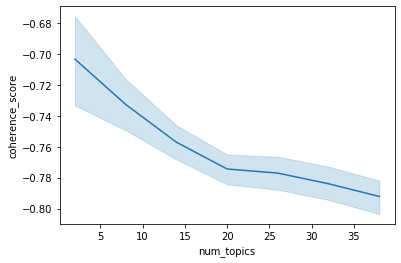

In [93]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [94]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

In [95]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

[(0, 0.016666684),
 (1, 0.016666694),
 (2, 0.016666694),
 (3, 0.016666736),
 (4, 0.5166665),
 (5, 0.016666668),
 (6, 0.26666668),
 (7, 0.016666673),
 (8, 0.016666668),
 (9, 0.01666668),
 (10, 0.016666675),
 (11, 0.016666682),
 (12, 0.016666668),
 (13, 0.016666668),
 (14, 0.016666668)]

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [78]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [79]:
test = "Ned asked me a question about England today."

In [80]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [81]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [82]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [129]:
people = get_people(doc_stream(path))

In [126]:
doc = nlp(next(doc_stream(path)))

In [128]:
doc.ents[0].lemma_

'yesterday'

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)